## Basic Information (Brain Lower Grade Glioma)



In [253]:
import numpy as np 
import pandas as pd 
import scanpy as sc 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

sc.settings.verbosity = 3 

sc.settings.set_figure_params(dpi = 80)
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import silhouette_score

## Gene Data

In [254]:
# read the gene expression data: 
raw_data_rna = pd.read_table("/Users/jinliu/Desktop/Practicum/MSK_brain_lower_grade_glioma_project/src/data_mrna_seq_v2_rsem.txt", sep="\t")
raw_data_rna.head()

,Hugo_Symbol,Entrez_Gene_Id,TCGA-CS-4938-01,TCGA-CS-4941-01,TCGA-CS-4942-01,TCGA-CS-4943-01,TCGA-CS-4944-01,TCGA-CS-5390-01,TCGA-CS-5393-01,TCGA-CS-5394-01,...,TCGA-VW-A8FI-01,TCGA-W9-A837-01,TCGA-WH-A86K-01,TCGA-WY-A858-01,TCGA-WY-A859-01,TCGA-WY-A85A-01,TCGA-WY-A85B-01,TCGA-WY-A85C-01,TCGA-WY-A85D-01,TCGA-WY-A85E-01
0,NaN,100130426,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,NaN,100133144,8.7141,36.4493,11.8131,8.6116,0.000,5.3382,3.7845,8.3071,...,19.1299,12.5770,10.9796,7.8225,3.3371,5.4526,8.2616,11.5121,5.3895,9.9433
2,UBE2Q2P2,100134869,22.7523,21.1767,11.0242,5.0835,30.261,27.8886,8.7230,15.4466,...,21.9905,27.0125,14.2608,16.6975,10.2310,16.1890,19.7074,18.7291,8.9103,7.4480
3,HMGB1P1,10357,268.5760,156.6870,185.1380,269.8360,216.341,159.7590,198.1880,208.5410,...,127.7470,106.8290,205.5170,184.4080,125.5470,124.9190,133.7390,120.9240,107.2540,143.0060
4,NaN,10431,845.8150,390.2690,621.4530,835.7290,812.508,576.9050,551.9470,607.8960,...,564.3620,603.3720,570.9130,760.7160,875.1410,658.2210,662.6510,524.7240,705.1280,748.5820


In [255]:
# choosing Entrez_Gene_Id as column because: 
print(f"There are {len(raw_data_rna[raw_data_rna.Entrez_Gene_Id.isna()])} genes has no ids")
print("we would use Entrez_Gene_Id as name of gene with a correponding dictionary table")
gene_symbol_id = raw_data_rna.iloc[:,:2].copy()
gene_symbol_id.tail()

There are 0 genes has no ids
we would use Entrez_Gene_Id as name of gene with a correponding dictionary table


,Hugo_Symbol,Entrez_Gene_Id
20526,ZYG11A,440590
20527,ZYG11B,79699
20528,ZYX,7791
20529,ZZEF1,23140
20530,ZZZ3,26009


In [256]:
# 
gene_symbol_id[gene_symbol_id.Entrez_Gene_Id == 3122]

,Hugo_Symbol,Entrez_Gene_Id
7912,HLA-DRA,3122


In [257]:
# transpose the data and make the gene id as the column names: 
df_clean = raw_data_rna.set_index("Entrez_Gene_Id").drop("Hugo_Symbol", axis = 1).transpose()
print(f"There are {len(df_clean)} samples in total, and there are {len(df_clean.columns)} genes in total.")
df_clean.head()

There are 514 samples in total, and there are 20531 genes in total.


Entrez_Gene_Id,100130426,100133144,100134869,10357,10431,136542,155060,26823,280660,317712,...,55055,11130,7789,158586,79364,440590,79699,7791,23140,26009
TCGA-CS-4938-01,0.0,8.7141,22.7523,268.576,845.815,0.0,182.505,0.4196,0.0,0.0,...,80.1636,50.3461,64.1913,523.180,1311.52,0.0000,1495.70,1598.91,1171.810,836.165
TCGA-CS-4941-01,0.0,36.4493,21.1767,156.687,390.269,0.0,325.052,1.7253,0.0,0.0,...,187.2980,110.4210,105.9350,467.564,1226.71,0.3451,1751.21,3889.92,1707.730,1015.530
TCGA-CS-4942-01,0.0,11.8131,11.0242,185.138,621.453,0.0,131.142,0.0000,0.0,0.0,...,120.0310,186.5050,115.2250,454.325,1102.42,0.3460,1586.16,2214.53,1423.880,706.920
TCGA-CS-4943-01,0.0,8.6116,5.0835,269.836,835.729,0.0,83.475,0.3261,0.0,0.0,...,667.4480,1183.6500,89.0183,491.068,1288.32,3.2607,1760.15,2131.55,1916.990,689.321
TCGA-CS-4944-01,0.0,0.0000,30.2610,216.341,812.508,0.0,80.696,0.0000,0.0,0.0,...,57.3244,56.4872,42.3654,323.793,1012.73,0.5044,1225.07,1692.60,729.794,456.941


In [258]:
# check the quality of the data: 
# 1) if there is any NA data
print(f"If there is NA values: {df_clean.isnull().values.any()}")

# 2) if there are columns with all the same value
unique_counts = df_clean.nunique()
same_value_cols = unique_counts[unique_counts == 1].index.tolist()
print(f"There are {len(same_value_cols)} columns with the same value.")
print(f"{same_value_cols[0:10]}...")

If there is NA values: False
There are 307 columns with the same value.
[136542, 317712, 728045, 728036, 255313, 728096, 728062, 653282, 728042, 57135]...


In [259]:
# thus, we need to drop all of same_value_cols: 
df_clean_1 = df_clean.drop(same_value_cols, axis = 1)
df_clean_1.head()

Entrez_Gene_Id,100130426,100133144,100134869,10357,10431,155060,26823,280660,340602,388795,...,55055,11130,7789,158586,79364,440590,79699,7791,23140,26009
TCGA-CS-4938-01,0.0,8.7141,22.7523,268.576,845.815,182.505,0.4196,0.0,2.0978,0.4196,...,80.1636,50.3461,64.1913,523.180,1311.52,0.0000,1495.70,1598.91,1171.810,836.165
TCGA-CS-4941-01,0.0,36.4493,21.1767,156.687,390.269,325.052,1.7253,0.0,3.4507,0.3451,...,187.2980,110.4210,105.9350,467.564,1226.71,0.3451,1751.21,3889.92,1707.730,1015.530
TCGA-CS-4942-01,0.0,11.8131,11.0242,185.138,621.453,131.142,0.0000,0.0,1.7301,0.3460,...,120.0310,186.5050,115.2250,454.325,1102.42,0.3460,1586.16,2214.53,1423.880,706.920
TCGA-CS-4943-01,0.0,8.6116,5.0835,269.836,835.729,83.475,0.3261,0.0,1.3043,0.0000,...,667.4480,1183.6500,89.0183,491.068,1288.32,3.2607,1760.15,2131.55,1916.990,689.321
TCGA-CS-4944-01,0.0,0.0000,30.2610,216.341,812.508,80.696,0.0000,0.0,3.0261,0.0000,...,57.3244,56.4872,42.3654,323.793,1012.73,0.5044,1225.07,1692.60,729.794,456.941


In [260]:
df_clean_1.index

Index(['TCGA-CS-4938-01', 'TCGA-CS-4941-01', 'TCGA-CS-4942-01',
       'TCGA-CS-4943-01', 'TCGA-CS-4944-01', 'TCGA-CS-5390-01',
       'TCGA-CS-5393-01', 'TCGA-CS-5394-01', 'TCGA-CS-5395-01',
       'TCGA-CS-5396-01',
       ...
       'TCGA-VW-A8FI-01', 'TCGA-W9-A837-01', 'TCGA-WH-A86K-01',
       'TCGA-WY-A858-01', 'TCGA-WY-A859-01', 'TCGA-WY-A85A-01',
       'TCGA-WY-A85B-01', 'TCGA-WY-A85C-01', 'TCGA-WY-A85D-01',
       'TCGA-WY-A85E-01'],
      dtype='object', length=514)

In [261]:
adata_gene = sc.AnnData(df_clean_1)

In [262]:
adata_gene

AnnData object with n_obs × n_vars = 514 × 20224

In [263]:
adata_gene.n_obs

514

In [264]:
adata_gene.var_names

Index(['100130426', '100133144', '100134869', '10357', '10431', '155060',
       '26823', '280660', '340602', '388795',
       ...
       '55055', '11130', '7789', '158586', '79364', '440590', '79699', '7791',
       '23140', '26009'],
      dtype='object', name='Entrez_Gene_Id', length=20224)

normalizing counts per cell
    finished (0:00:00)


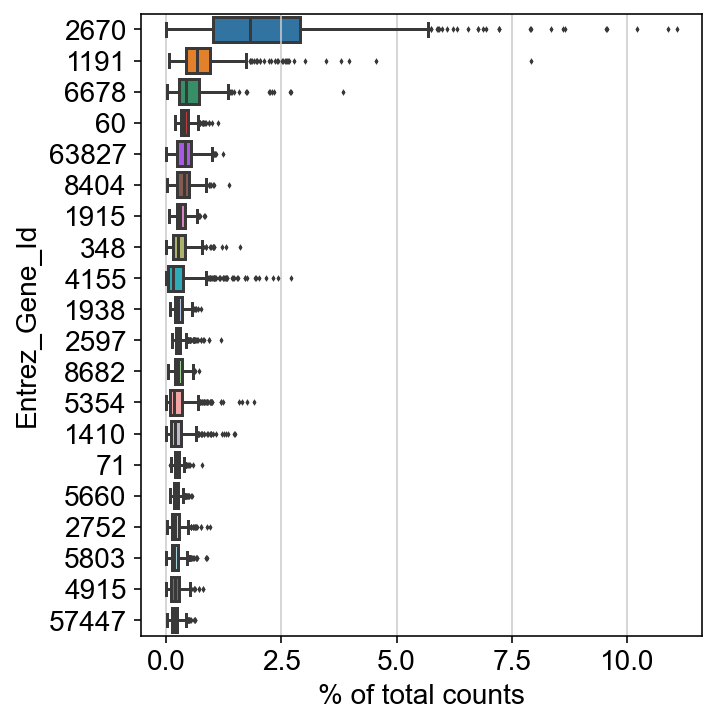

In [265]:
sc.pl.highest_expr_genes(adata_gene, n_top=20, )
#Show those genes that yield the highest fraction of counts in each single cell, across all cells.

In [266]:
# filter cell outliers based on counts and numbers of genes expressed 
# sc.pp.filter_cells(adata_gene, min_genes=200)
# sc.pp.filter_genes(adata_gene, min_cells = 3)

In [267]:
sc.tl.pca(adata_gene, svd_solver='arpack')
sc.pp.neighbors(adata_gene, n_neighbors=30, n_pcs=50)
sc.tl.umap(adata_gene, min_dist=0.3) 

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


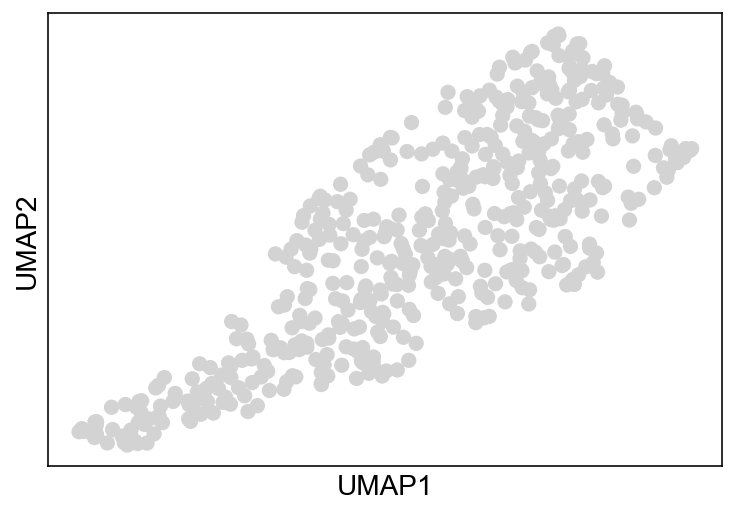

In [268]:
sc.pl.umap(adata_gene)

## Mutation Data

In [269]:
raw_data_mutation = pd.read_table("/Users/jinliu/Desktop/Practicum/MSK_brain_lower_grade_glioma_project/src/data_mutations.txt", sep="\t")
raw_data_mutation

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Consequence,Variant_Classification,...,SYMBOL_SOURCE,TREMBL,TSL,UNIPARC,VARIANT_CLASS,all_effects,cDNA_position,n_depth,t_depth,Annotation_Status
0,CELF6,60677.0,.,GRCh37,15,72608207,72608207,+,synonymous_variant,Silent,...,HGNC,B3KWE6_HUMAN,.,UPI000006F0AA,SNV,"CELF6,synonymous_variant,p.%3D,ENST00000567083...",579,17,18,SUCCESS
1,GPR114,0.0,.,GRCh37,16,57601804,57601804,+,missense_variant,Missense_Mutation,...,HGNC,.,.,UPI0000039944,SNV,"GPR114,missense_variant,p.Asn286Lys,ENST000003...",1381,43,47,SUCCESS
2,TP53,7157.0,.,GRCh37,17,7577539,7577539,+,missense_variant,Missense_Mutation,...,HGNC,"S5LQU8_HUMAN,Q761V2_HUMAN,Q6IT77_HUMAN,Q1HGV1_...",.,UPI000002ED67,SNV,"TP53,missense_variant,p.Arg248Trp,ENST00000413...",932,117,102,SUCCESS
3,KLK10,5655.0,.,GRCh37,19,51518742,51518742,+,synonymous_variant,Silent,...,HGNC,M0R132_HUMAN,.,UPI000013CCB0,SNV,"KLK10,synonymous_variant,p.%3D,ENST00000391805...",828,363,364,SUCCESS
4,C3,718.0,.,GRCh37,19,6686853,6686853,+,stop_gained,Nonsense_Mutation,...,HGNC,"Q6LDJ0_HUMAN,M0R1Q1_HUMAN",.,UPI000013EC9B,SNV,"C3,stop_gained,p.Gln49Ter,ENST00000601008,;C3,...",3643,163,144,SUCCESS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39294,CABP5,56344.0,.,GRCh37,19,48533797,48533797,+,3_prime_UTR_variant,3'UTR,...,HGNC,.,.,UPI0000126D6A,SNV,"CABP5,3_prime_UTR_variant,,ENST00000293255,;",670,42,81,SUCCESS
39295,HIST1H2BD,0.0,.,GRCh37,6,26158800,26158800,+,intron_variant,Intron,...,HGNC,.,.,UPI0000001BD3,SNV,"HIST1H2BD,3_prime_UTR_variant,,ENST00000377777...",.,40,60,SUCCESS
39296,HOXA2,3199.0,.,GRCh37,7,27140265,27140265,+,3_prime_UTR_variant,3'UTR,...,HGNC,.,.,UPI0000049C49,SNV,"HOXA2,3_prime_UTR_variant,,ENST00000222718,;HO...",1522,25,40,SUCCESS
39297,PLIN2,123.0,.,GRCh37,9,19116192,19116192,+,3_prime_UTR_variant,3'UTR,...,HGNC,"Q6FHZ7_HUMAN,Q5SYF5_HUMAN,B4DJK9_HUMAN",.,UPI0000125535,SNV,"PLIN2,3_prime_UTR_variant,,ENST00000276914,;PL...",1548,42,38,SUCCESS


In [270]:
raw_data_mutation.iloc[0,:]

Hugo_Symbol                                                      CELF6
Entrez_Gene_Id                                                 60677.0
Center                                                               .
NCBI_Build                                                      GRCh37
Chromosome                                                          15
                                           ...                        
all_effects          CELF6,synonymous_variant,p.%3D,ENST00000567083...
cDNA_position                                                      579
n_depth                                                             17
t_depth                                                             18
Annotation_Status                                              SUCCESS
Name: 0, Length: 114, dtype: object

## Clinical Patient

In [271]:
raw_data_sample = pd.read_table("/Users/jinliu/Desktop/Practicum/MSK_brain_lower_grade_glioma_project/src/data_clinical_sample.txt", sep="\t")
df_sample2 = pd.read_table("/Users/jinliu/Desktop/Practicum/MSK_brain_lower_grade_glioma_project/src/lgg_tcga_pan_can_atlas_2018/Clinical_Data.tsv", sep = '\t')

In [272]:
raw_data_sample.columns = raw_data_sample.iloc[3,:]
raw_data_sample = raw_data_sample.drop([0,1,2,3], axis = 0)
df_patient = raw_data_sample.reset_index().drop(["index"], axis = 1)

In [273]:
df_full = df_patient.merge(df_sample2, left_on = "PATIENT_ID", right_on = "Patient ID", how = "left")

In [274]:
df_full_1 = df_full.drop(['Patient ID', 'Sample ID','Cancer Type Detailed','Tumor Type', 'Aneuploidy Score'], axis = 1)

In [275]:
len(df_full_1.iloc[0,:])

31

In [276]:
len(df_patient.iloc[0,:])

18

## Creating anndata with sample as its obs:

In [277]:
df_sample_with_gene = df_clean_1.merge(df_full_1, left_index=True, right_on = "SAMPLE_ID")

In [278]:
X = df_sample_with_gene.iloc[:,0:-30].copy()
X = X.set_index("PATIENT_ID")
obs = df_sample_with_gene.iloc[:,-31:].copy()
obs = obs.set_index("PATIENT_ID")
adata_sample = sc.AnnData(X, obs = obs)

In [279]:
adata_sample.X

array([[   0.    ,    8.7141,   22.7523, ..., 1598.91  , 1171.81  ,
         836.165 ],
       [   0.    ,   36.4493,   21.1767, ..., 3889.92  , 1707.73  ,
        1015.53  ],
       [   0.    ,   11.8131,   11.0242, ..., 2214.53  , 1423.88  ,
         706.92  ],
       ...,
       [   0.    ,   11.5121,   18.7291, ..., 1927.67  , 2006.13  ,
         910.094 ],
       [   0.    ,    5.3895,    8.9103, ..., 1706.11  , 1429.49  ,
         771.203 ],
       [   0.    ,    9.9433,    7.448 , ..., 2043.86  , 1434.4   ,
         626.465 ]], dtype=float32)

In [280]:
adata_sample.obs

,SAMPLE_ID,ONCOTREE_CODE,CANCER_TYPE,CANCER_TYPE_DETAILED,TUMOR_TYPE,GRADE,TISSUE_PROSPECTIVE_COLLECTION_INDICATOR,TISSUE_RETROSPECTIVE_COLLECTION_INDICATOR,TISSUE_SOURCE_SITE_CODE,TUMOR_TISSUE_SITE,...,MSI MANTIS Score,MSIsensor Score,Overall Survival Status,Sex,Ethnicity Category,Race Category,Subtype,Birth from Initial Pathologic Diagnosis Date,Buffa Hypoxia Score,Somatic Status
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-CS-4938,TCGA-CS-4938-01,DIFG,Glioma,Astrocytoma,Astrocytoma,G2,No,Yes,CS,CNS,...,0.3030,0.00,0:LIVING,Female,Not Hispanic Or Latino,White,LGG_IDHmut-non-codel,-11509.0,-27,Matched
TCGA-CS-4941,TCGA-CS-4941-01,DIFG,Glioma,Astrocytoma,Astrocytoma,G3,No,Yes,CS,CNS,...,0.2736,0.00,1:DECEASED,Male,Not Hispanic Or Latino,White,LGG_IDHwt,-24578.0,-33,Matched
TCGA-CS-4942,TCGA-CS-4942-01,DIFG,Glioma,Astrocytoma,Astrocytoma,G3,No,Yes,CS,CNS,...,0.2810,0.02,1:DECEASED,Female,NaN,Black or African American,LGG_IDHmut-non-codel,-16297.0,-27,Matched
TCGA-CS-4943,TCGA-CS-4943-01,DIFG,Glioma,Astrocytoma,Astrocytoma,G3,No,Yes,CS,CNS,...,0.2751,0.25,1:DECEASED,Male,NaN,White,LGG_IDHmut-non-codel,-13565.0,-11,Matched
TCGA-CS-4944,TCGA-CS-4944-01,DIFG,Glioma,Astrocytoma,Astrocytoma,G2,No,Yes,CS,CNS,...,0.2697,0.04,0:LIVING,Male,NaN,White,LGG_IDHmut-non-codel,-18494.0,-11,Matched
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WY-A85A,TCGA-WY-A85A-01,DIFG,Glioma,Astrocytoma,Astrocytoma,G2,No,Yes,WY,CNS,...,0.3252,0.02,0:LIVING,Male,NaN,White,LGG_IDHmut-non-codel,-7380.0,-25,Matched
TCGA-WY-A85B,TCGA-WY-A85B-01,DIFG,Glioma,Astrocytoma,Astrocytoma,G2,No,Yes,WY,CNS,...,0.3309,0.03,0:LIVING,Male,NaN,White,LGG_IDHmut-non-codel,-8817.0,-23,Matched
TCGA-WY-A85C,TCGA-WY-A85C-01,DIFG,Glioma,Astrocytoma,Astrocytoma,G2,No,Yes,WY,CNS,...,0.3184,0.04,0:LIVING,Male,NaN,White,LGG_IDHmut-non-codel,-13506.0,-23,Matched


### At here, we used PCA analysis on the gene expression data. By plotting the results of PCA colored by tumor type and grade, we can visualize how the samples are distributed in this lower-dimensional space based on their clinical characteristics. 
###  As we can see from the tumor PCA graph, there is no clear separation between samples from different tumor types and grades, this suggests that gene expression differences are not strongly associated with these tumor types and grades. 

In [281]:
sc.tl.pca(adata_sample, svd_solver = "arpack")

computing PCA
    with n_comps=50
    finished (0:00:00)


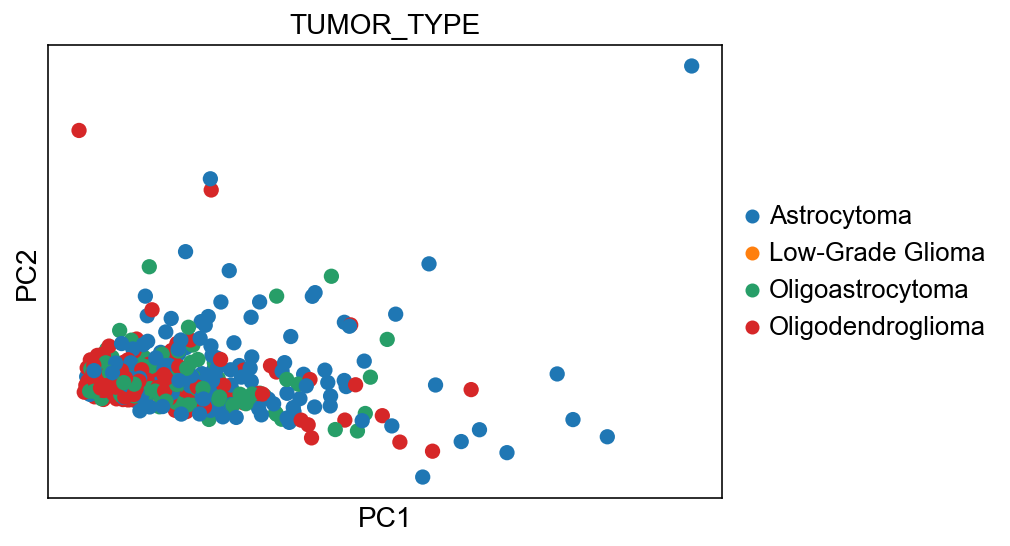

In [282]:
sc.pl.pca(adata_sample, color = ["TUMOR_TYPE"])

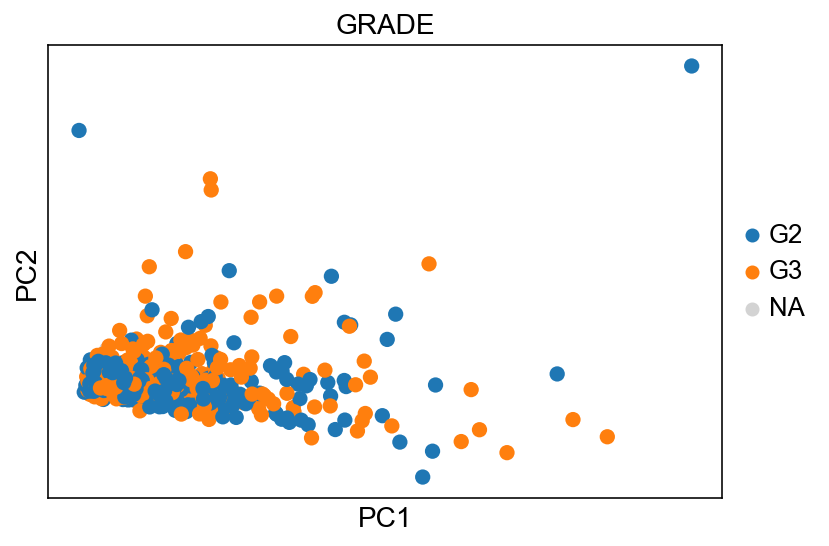

In [283]:
sc.pl.pca(adata_sample, color = ["GRADE"])

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


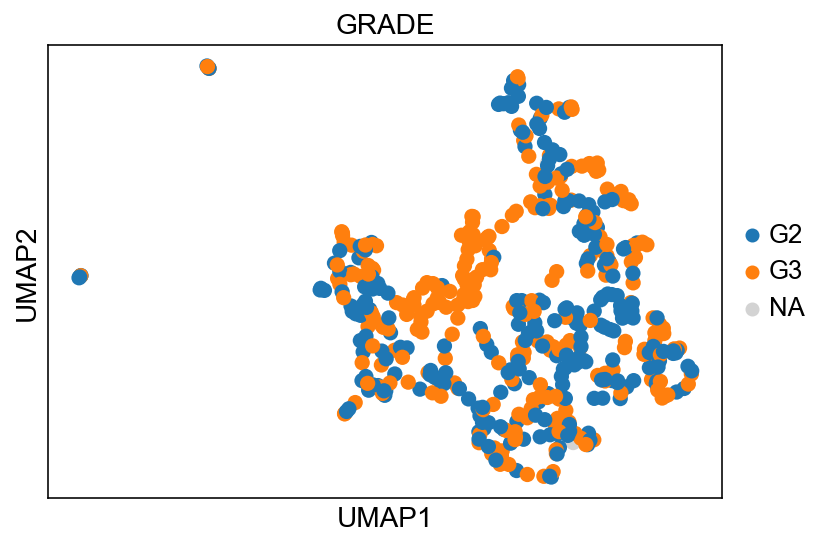

In [284]:
sc.pp.neighbors(adata_sample, n_neighbors=3)
sc.tl.umap(adata_sample, min_dist=0.3)
sc.pl.umap(adata_sample, color = ["GRADE"])

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


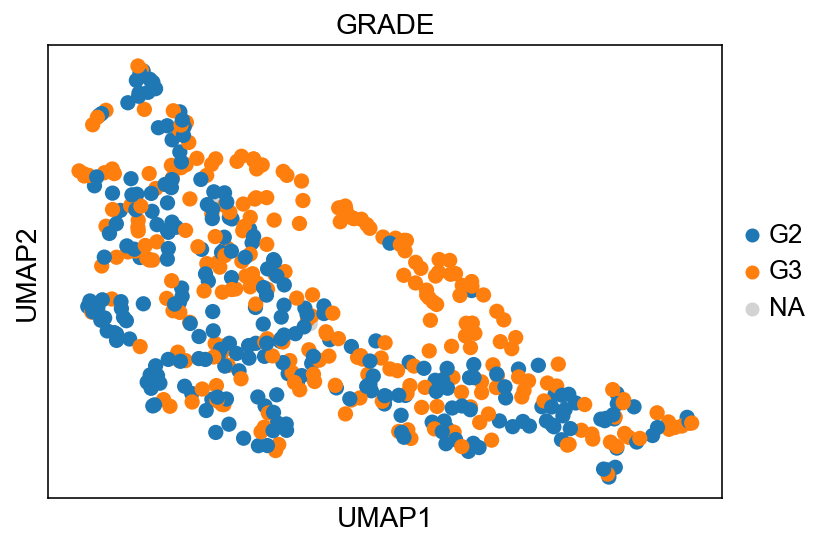

In [285]:
sc.pp.neighbors(adata_sample, n_neighbors=5)
sc.tl.umap(adata_sample, min_dist=0.3)
sc.pl.umap(adata_sample, color = ["GRADE"])

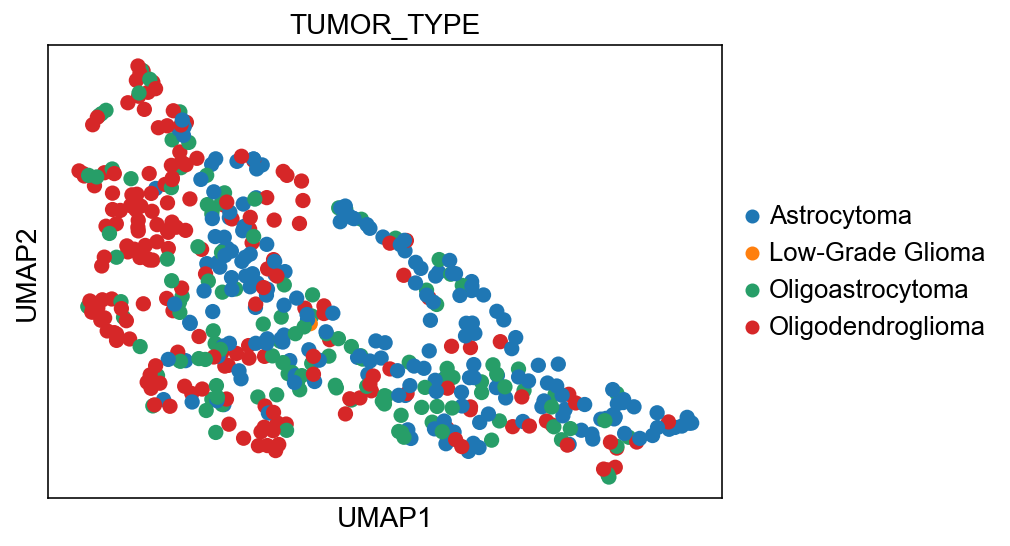

In [286]:
sc.pl.umap(adata_sample, color = ["TUMOR_TYPE"])

computing PCA
    with n_comps=50
    finished (0:00:01)


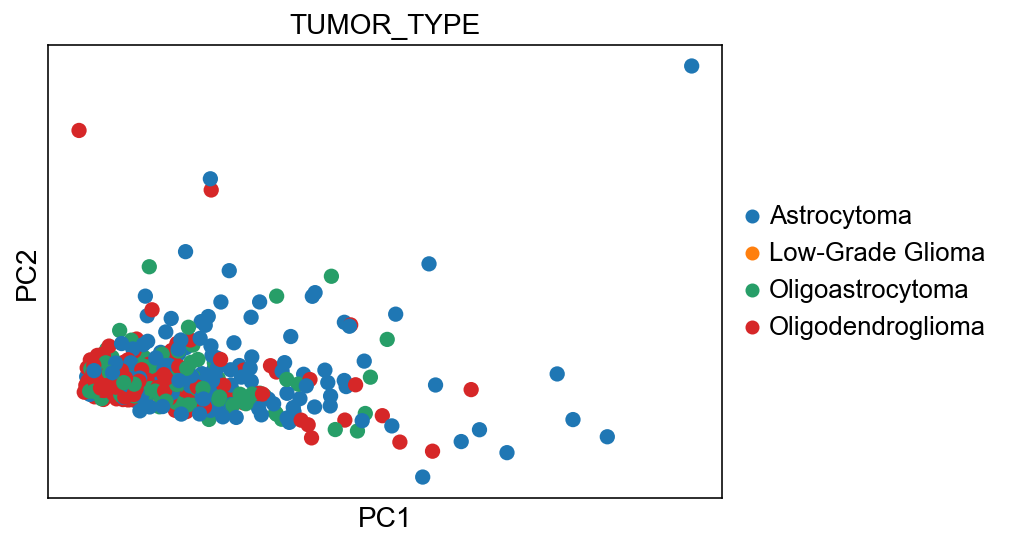

In [287]:
# Import necessary libraries
import scanpy as sc

sc.tl.pca(adata_sample, svd_solver="full", n_comps=50)


# Plot PCA results colored by tumor type
sc.pl.pca(adata_sample, color="TUMOR_TYPE")



computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


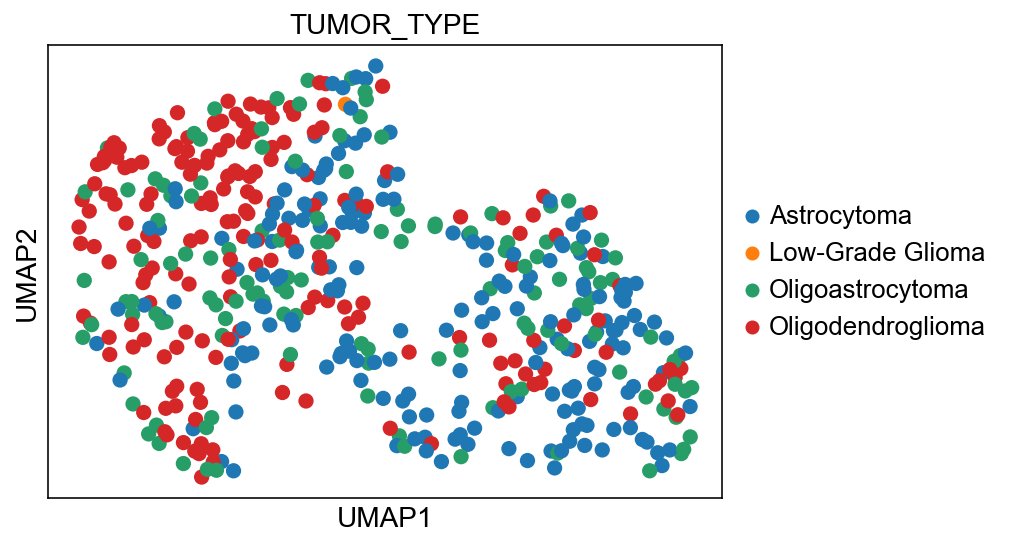

In [288]:
# Perform UMAP with different hyperparameters
sc.pp.neighbors(adata_sample, n_neighbors=10, metric="cosine")
sc.tl.umap(adata_sample, min_dist=0.5)
sc.pl.umap(adata_sample, color=["TUMOR_TYPE"])


computing neighbors
    finished: added to `.uns['neighbors_euclidean']`
    `.obsp['neighbors_euclidean_distances']`, distances for each pair of neighbors
    `.obsp['neighbors_euclidean_connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


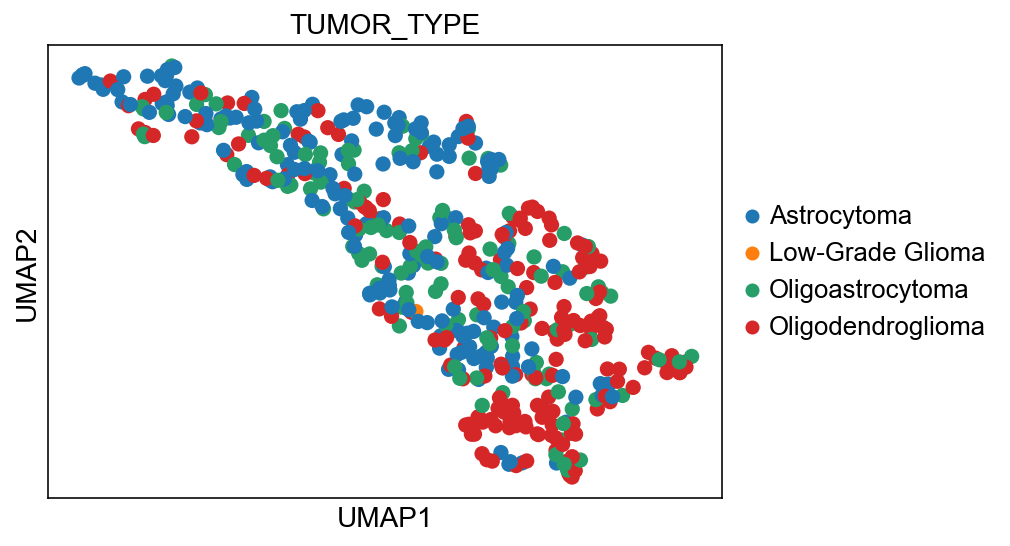

In [289]:
sc.pp.neighbors(adata_sample, n_neighbors=5, key_added="neighbors_euclidean", use_rep="X")
sc.tl.umap(adata_sample, neighbors_key="neighbors_euclidean", min_dist=0.3)
sc.pl.umap(adata_sample, color=["TUMOR_TYPE"])


In [290]:
# Convert the sample metadata to a Pandas DataFrame
metadata_df = adata_sample.obs.reset_index()

# Split the data into training and testing sets
X = metadata_df[['ONCOTREE_CODE', 'TUMOR_TYPE', 'GRADE']] # Features
y = metadata_df['CANCER_TYPE_DETAILED'] # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the OneHotEncoder to the training set
encoder = OneHotEncoder()
encoder.fit(X_train[['ONCOTREE_CODE', 'TUMOR_TYPE', 'GRADE']])

# Transform the features of the training and test sets using the encoder
X_train_encoded = encoder.transform(X_train[['ONCOTREE_CODE', 'TUMOR_TYPE', 'GRADE']])
X_test_encoded = encoder.transform(X_test[['ONCOTREE_CODE', 'TUMOR_TYPE', 'GRADE']])

# Convert the encoded features to a dense array
X_train_encoded_dense = X_train_encoded.toarray()
X_test_encoded_dense = X_test_encoded.toarray()

# Create a new DataFrame with the encoded features
X_train_encoded_df = pd.DataFrame(X_train_encoded_dense, columns=encoder.get_feature_names())
X_test_encoded_df = pd.DataFrame(X_test_encoded_dense, columns=encoder.get_feature_names())


# Fit the logistic regression model
model = LogisticRegression()
model.fit(X_train_encoded_df, y_train)

# Predict the Y values for the test set
y_pred = model.predict(X_test_encoded_df)

# Evaluate the model performance using accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Extract the coefficients of the model
coefficients = model.coef_

# Print the coefficients of the model
for i in range(len(coefficients[0])):
    print('Coefficient for {}: {}'.format(X_train_encoded_df.columns[i], coefficients[0][i]))


Accuracy: 1.0
Coefficient for x0_DIFG: 1.7906944407478291
Coefficient for x0_LGGNOS: -0.21660511884370223
Coefficient for x0_OAST: -0.766000560088208
Coefficient for x0_ODG: -0.8081329837735295
Coefficient for x1_Astrocytoma: 1.7906944407478291
Coefficient for x1_Low-Grade Glioma: -0.21660511884370223
Coefficient for x1_Oligoastrocytoma: -0.766000560088208
Coefficient for x1_Oligodendroglioma: -0.8081329837735295
Coefficient for x2_G2: -0.010766996706019005
Coefficient for x2_G3: 0.23435673692945352
Coefficient for x2_nan: -0.22363396218104453


In [291]:
y_train

320    Oligodendroglioma
329    Oligodendroglioma
173    Oligodendroglioma
272    Oligodendroglioma
493    Oligodendroglioma
             ...        
106    Oligodendroglioma
270          Astrocytoma
348     Oligoastrocytoma
435     Oligoastrocytoma
102          Astrocytoma
Name: CANCER_TYPE_DETAILED, Length: 411, dtype: category
Categories (4, object): ['Astrocytoma', 'Low-Grade Glioma (NOS)', 'Oligoastrocytoma', 'Oligodendroglioma']

In [292]:
# preprocessing the data: encode, drop nan, scale? 
X= pd.DataFrame(adata_sample.X)
X.columns = adata_sample.var_names
X.index = metadata_df.index
y = adata_sample.obs['Subtype']
df = pd.concat([X,y], axis = 1)

In [304]:
df = adata_sample.obs

In [303]:
metadata_df.columns

Index(['PATIENT_ID', 'SAMPLE_ID', 'ONCOTREE_CODE', 'CANCER_TYPE',
       'CANCER_TYPE_DETAILED', 'TUMOR_TYPE', 'GRADE',
       'TISSUE_PROSPECTIVE_COLLECTION_INDICATOR',
       'TISSUE_RETROSPECTIVE_COLLECTION_INDICATOR', 'TISSUE_SOURCE_SITE_CODE',
       'TUMOR_TISSUE_SITE', 'ANEUPLOIDY_SCORE', 'SAMPLE_TYPE',
       'MSI_SCORE_MANTIS', 'MSI_SENSOR_SCORE', 'SOMATIC_STATUS',
       'TMB_NONSYNONYMOUS', 'TISSUE_SOURCE_SITE', 'Mutation Count',
       'Fraction Genome Altered', 'Diagnosis Age', 'MSI MANTIS Score',
       'MSIsensor Score', 'Overall Survival Status', 'Sex',
       'Ethnicity Category', 'Race Category', 'Subtype',
       'Birth from Initial Pathologic Diagnosis Date', 'Buffa Hypoxia Score',
       'Somatic Status'],
      dtype='object')

In [313]:
from sklearn.metrics import r2_score

df.dropna(inplace=True)

# Split the data into training and testing sets
X = df.drop('Mutation Count', axis=1)
y = df['Mutation Count']

categorical_columns = list(X.select_dtypes(include=['category', 'object']).columns)
X_encoded = pd.get_dummies(X, columns=categorical_columns)


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Fit a linear regression model on the training set
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model on the testing set
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)


mse = mean_squared_error(y_test, y_pred)
print(f'Mean squared error: {mse}')
print(f'R-squared: {r2}')

Mean squared error: 8100.792835393206
R-squared: -45.47660982946169


In [307]:
X_train_encoded.shape

(364, 942)

In [308]:
X_test_encoded.shape

(91, 669)

In [309]:
X_train.shape

(364, 29)

In [314]:
X_encoded

,Fraction Genome Altered,Diagnosis Age,MSI MANTIS Score,MSIsensor Score,Birth from Initial Pathologic Diagnosis Date,Buffa Hypoxia Score,SAMPLE_ID_TCGA-CS-4938-01,SAMPLE_ID_TCGA-CS-4941-01,SAMPLE_ID_TCGA-CS-5396-01,SAMPLE_ID_TCGA-CS-5397-01,...,Ethnicity Category_Hispanic Or Latino,Ethnicity Category_Not Hispanic Or Latino,Race Category_American Indian or Alaska Native,Race Category_Asian,Race Category_Black or African American,Race Category_White,Subtype_LGG_IDHmut-codel,Subtype_LGG_IDHmut-non-codel,Subtype_LGG_IDHwt,Somatic Status_Matched
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-CS-4938,0.0518,31.0,0.3030,0.00,-11509.0,-27,1,0,0,0,...,0,1,0,0,0,1,0,1,0,1
TCGA-CS-4941,0.2241,67.0,0.2736,0.00,-24578.0,-33,0,1,0,0,...,0,1,0,0,0,1,0,0,1,1
TCGA-CS-5396,0.1259,53.0,0.2798,0.00,-19399.0,-35,0,0,1,0,...,0,1,0,0,0,1,1,0,0,1
TCGA-CS-5397,0.2628,54.0,0.2936,0.00,-19866.0,-29,0,0,0,1,...,0,1,0,0,0,1,0,0,1,1
TCGA-CS-6186,0.1518,58.0,0.2942,0.02,-21321.0,-31,0,0,0,0,...,0,1,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-TQ-A8XE,0.0962,42.0,0.3362,0.00,-15629.0,-29,0,0,0,0,...,1,0,0,0,0,1,0,1,0,1
TCGA-VV-A829,0.1230,44.0,0.3226,0.04,-16163.0,-31,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1
TCGA-VW-A7QS,0.0862,35.0,0.3031,0.23,-12820.0,-3,0,0,0,0,...,0,1,0,1,0,0,1,0,0,1
